This notebook explores and visualizes **gravity anomaly GeoTIFF files** before they are merged with sample point data. The goal is to understand the value distribution, spatial extent, NoData handling, and potential preprocessing steps for gravity features.

---

## 1.Gravity Data Files
We focus on the following gravity anomaly datasets provided by **Geoscience Australia**:

| File Name | Description |
|-----------|-------------|
| `Gravmap2016-grid-grv_ir.tif` | Isostatic residual gravity anomaly (shallow, filtered) |
| `Gravmap2019-grid-grv_cscba.tif` | Complete Spherical Cap Bouguer Anomaly (deep regional trend) |
| `Gravmap2019-grid-grv_cscba_1vd.tif` | First vertical derivative of CSCBA (enhances linear structures) |

All datasets are in GeoTIFF format, with a single band and float32 pixel values.


## 2.Raster Metadata Inspection
We use `rasterio` to inspect and understand:
- Coordinate Reference System (CRS)
- Affine transform (pixel-to-coordinate)
- Bounds and spatial coverage
- Resolution (pixel size)
- NoData values
- Min/Max value range

In [1]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# read file path
gravity_iso_residual = "../../data/raw/Dataset/GA/Gravity/Gravmap2016-grid-grv_ir.tif"
gravity_cscba = "../../data/raw/Dataset/GA/Gravity/Gravmap2019-grid-grv_cscba.tif"
gravity_cscba_1vd = "../../data/raw/Dataset/GA/Gravity/Gravmap2019-grid-grv_cscba_1vd.tif"

In [2]:
# define geotiff metadata function
def inspect_geotiff_metadata(file, title=None):
    with rasterio.open(file) as src:
        print("CRS:", src.crs)
        print("Transform:", src.transform)
        print("Bounds:", src.bounds)
        print("Width x Height:", src.width, "x", src.height)
        print("Data Type:", src.dtypes)
        print("NoData Value:", src.nodata)
        print("Resolution:", src.res)
        band = src.read(1)
        print("Min:", band.min(), "Max:", band.max())

In [4]:
inspect_geotiff_metadata(gravity_iso_residual, title="Isostatic Residual Gravity Anomaly")

CRS: GEOGCS["GDA94",DATUM["unnamed",SPHEROID["unnamed",6378137,298.257222101004]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
Transform: | 0.01, 0.00, 112.50|
| 0.00,-0.01,-10.10|
| 0.00, 0.00, 1.00|
Bounds: BoundingBox(left=112.4975, bottom=-44.268, right=154.173, top=-10.098)
Width x Height: 4903 x 4020
Data Type: ('float32',)
NoData Value: -99999.0
Resolution: (0.0085, 0.0085)
Min: -99999.0 Max: 1167.2439


In [5]:
inspect_geotiff_metadata(gravity_cscba, title="Complete Spherical Cap Bouguer Anomaly (CSCBA)")

CRS: GEOGCS["GDA94",DATUM["unnamed",SPHEROID["unnamed",6378137,298.257222101004]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
Transform: | 0.00, 0.00, 111.00|
| 0.00,-0.00,-8.00|
| 0.00, 0.00, 1.00|
Bounds: BoundingBox(left=110.99600000000001, bottom=-45.0, right=156.0, top=-8.0)
Width x Height: 11251 x 9250
Data Type: ('float32',)
NoData Value: -999999.0
Resolution: (0.004, 0.004)
Min: -1694.2098 Max: 4276.54


In [6]:
inspect_geotiff_metadata(gravity_cscba_1vd, title="First Vertical Derivative of CSCBA (1VD)")

CRS: GEOGCS["GDA94",DATUM["unnamed",SPHEROID["unnamed",6378137,298.257222101004]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
Transform: | 0.00, 0.00, 111.00|
| 0.00,-0.00,-8.00|
| 0.00, 0.00, 1.00|
Bounds: BoundingBox(left=110.99600000000001, bottom=-45.0, right=156.0, top=-8.0)
Width x Height: 11251 x 9250
Data Type: ('float32',)
NoData Value: -99999.0
Resolution: (0.004, 0.004)
Min: -134624.6 Max: 117166.88


In [69]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

def plot_geotiff_with_scaling(file, title=None, vmin=None, vmax=None):
    with rasterio.open(file) as src:
        band = src.read(1)
        band = np.where(band == src.nodata, np.nan, band)

        if vmin is None or vmax is None:
            vmin = np.nanpercentile(band, 2)
            vmax = np.nanpercentile(band, 98)

        plt.figure(figsize=(8, 6))
        plt.imshow(band, cmap='viridis', vmin=vmin, vmax=vmax)
        plt.colorbar(label="Anomaly Value")
        plt.title(title or file, fontsize=14, weight="bold")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.show()

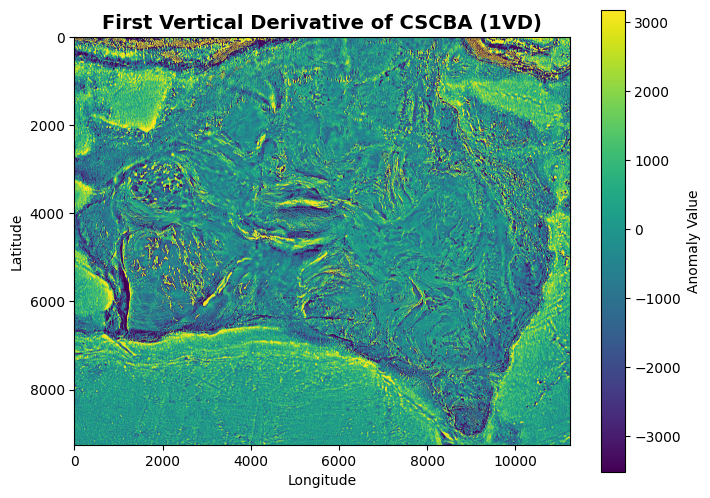

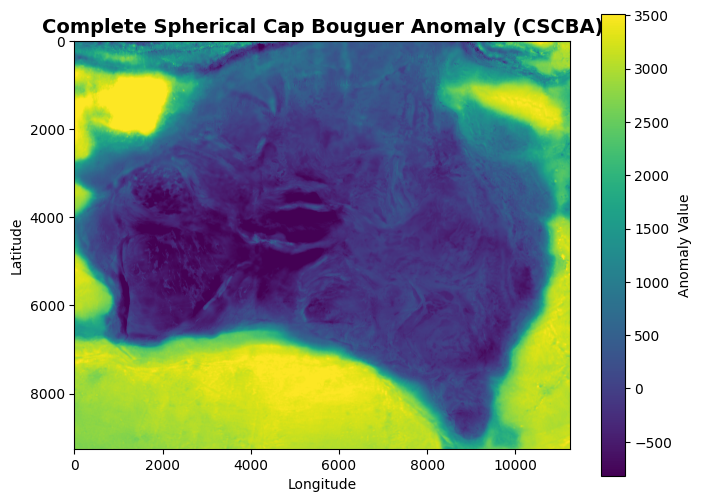

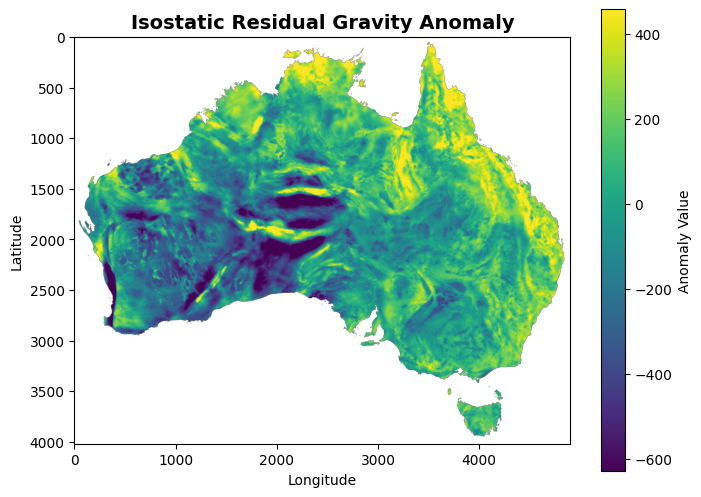

In [70]:
plot_geotiff_with_scaling(gravity_cscba_1vd, title="First Vertical Derivative of CSCBA (1VD)")
plot_geotiff_with_scaling(gravity_cscba, title="Complete Spherical Cap Bouguer Anomaly (CSCBA)")
plot_geotiff_with_scaling(gravity_iso_residual, title="Isostatic Residual Gravity Anomaly")

## 3.Distribution of Pixel Values
We explore the histogram of raw pixel values (excluding NoData):

In [74]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pixel_distribution(band, nodata_value, title="Value Distribution", unit="mGal", bins=100):
    valid_pixels = band[band != nodata_value]

    print(f"Pixel Count: {valid_pixels.size}")
    print(f"Min: {np.min(valid_pixels):.2f}, Max: {np.max(valid_pixels):.2f}")
    print(f"Mean: {np.mean(valid_pixels):.2f}, Median: {np.median(valid_pixels):.2f}, Std: {np.std(valid_pixels):.2f}")

    plt.figure(figsize=(8, 5))
    plt.hist(valid_pixels.flatten(), bins=bins, color="steelblue", edgecolor="white")
    plt.title(title)
    plt.xlabel(f"Anomaly Value ({unit})")
    plt.ylabel("Pixel Count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Pixel Count: 9651294
Min: -1289.85, Max: 1167.24
Mean: -12.31, Median: 8.88, Std: 257.40


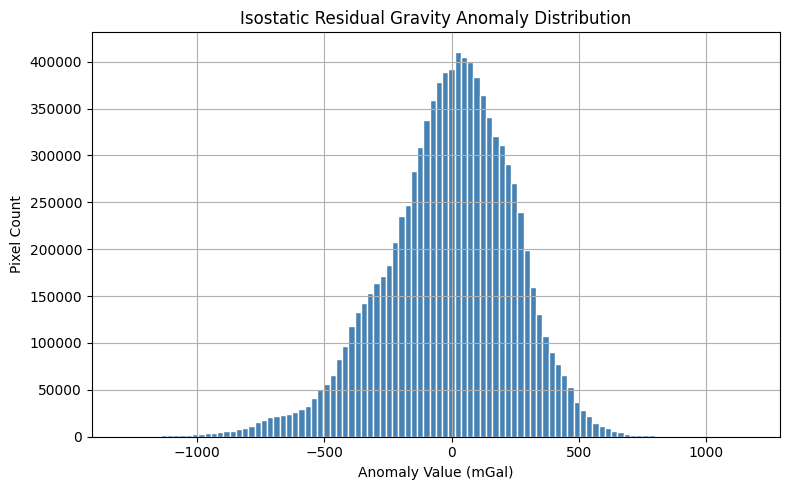

Pixel Count: 104071750
Min: -1694.21, Max: 4276.54
Mean: 1033.52, Median: 370.05, Std: 1453.55


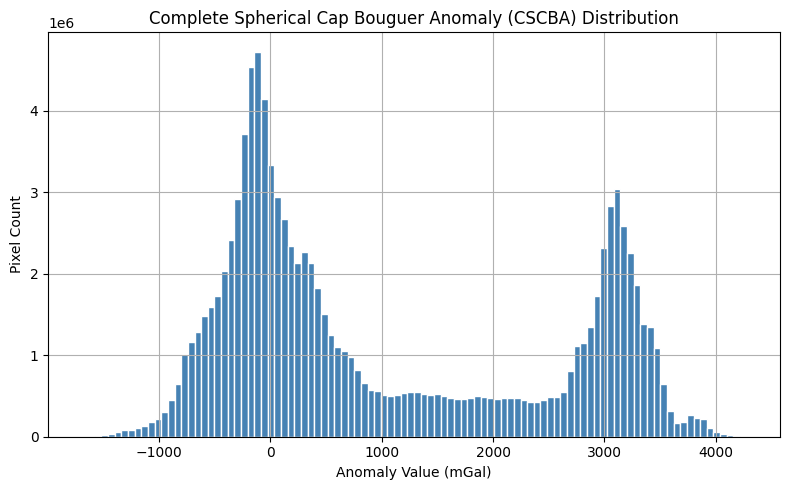

Pixel Count: 104071750
Min: -134624.59, Max: 117166.88
Mean: -65.48, Median: -22.32, Std: 1957.67


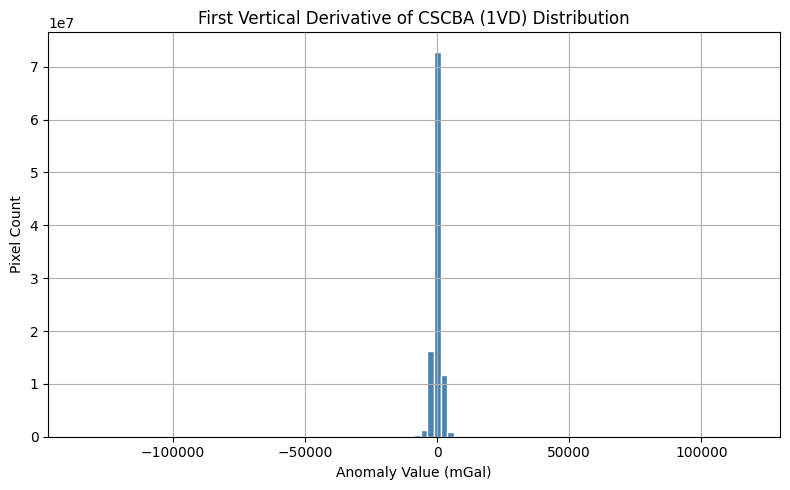

In [77]:
plot_pixel_distribution(rasterio.open(gravity_iso_residual).read(1), nodata_value=-99999, title="Isostatic Residual Gravity Anomaly Distribution")
plot_pixel_distribution(rasterio.open(gravity_cscba).read(1), nodata_value=-99999, title="Complete Spherical Cap Bouguer Anomaly (CSCBA) Distribution")
plot_pixel_distribution(rasterio.open(gravity_cscba_1vd).read(1), nodata_value=-99999, title="First Vertical Derivative of CSCBA (1VD) Distribution")

## 4.NoData Handling
- NoData value: typically `-99999.0` or `-999999.0`
- These must be masked prior to interpolation or extraction
- They can distort summary statistics and visualizations